In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import geopandas as gpd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from tqdm import tqdm

from IPython.display import FileLink

from geopy.geocoders import Nominatim
import overpass
import requests

from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon
from geopy import distance

import folium
from folium.plugins import HeatMap

### Задача:

Прогноз продаж одной из популярных моделей [фичерфонов](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D1%87%D0%B5%D1%80%D1%84%D0%BE%D0%BD) (на картинке ниже пример похожего устройства) в салонах МегаФона
![](https://39.img.avito.st/640x480/8468720439.jpg)

### Исходные данные:

Датасет содержит следующие поля:

1. `point_id` - Индентификатор салона
2. `lon` - Долгота точки
3. `lat` - Широта точки
4. `target` - Значение таргета, усредненное за несколько месяцев и отнормированное

### Требования к решению и советы:

Ниже приведен список из нескольких важных пунктов, необходимых для решения задания. Выполнение каждого из пунктов влияет на итоговую оценку. Вы можете выполнить каждый из пунктов разными способами, самым лучшим будет считаться вариант, когда всё получение и обработка данных будут реализованы на Питоне (пример: вы можете скачать данные из OSM через интерфейс на сайте overpass-turbo или с помощью библиотек `overpass`/`requests`. Оба варианта будут зачтены, но больше баллов можно заработать во втором случае)



1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))


2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```
5. Задание не ограничено приведенными выше пунктами, попробуйте нагенерировать интересных признаков, найти в интернете дополнительные данные (в таком случае в комментарии к коду укажите ссылку на ресурс, откуда взяли данные)



6. Это довольно сложная задача - датасет очень маленький, данные по своей природе довольно случайны. Поэтому место и скор на Kaggle не будут играть решающую роль в оценке, но позволят заработать дополнительные баллы

### Read data

In [ ]:
train = pd.read_csv('data/mf_geo_train.csv')
test = pd.read_csv('data/mf_geo_test.csv')

In [ ]:
train.head(2)

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206


In [ ]:
test.head(2)

,point_id,lon,lat,target
0,F4lXR1cG,37.681242,55.74804,0.0091
1,4LJu4GTf,60.580910,56.79586,0.0091


### Tasks

1. Салоны расположены в нескольких разных городах, вам необходимо **определить город для каждого салона** (это понадобится во многих частях задания). К этому есть разные подходы. Вы можете провести [обратное геокодирование](https://en.wikipedia.org/wiki/Reverse_geocoding) с помощью геокодера [Nominatim](https://nominatim.org/), доступного через библиотеку `geopy` примерно вот так:
```python
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.reverse("52.509669, 13.376294")
print(location.address)
```
В таком случае, вам придется обрабатывать полученную строку адреса, чтобы извлечь название города. Также вы можете скачать из OSM или найти в любом другом источнике границы административно территориальных границ России и пересечь с ними датасет с помощью `geopandas.sjoin` (этот вариант более надежный, но нужно будет разобраться с тем, как устроены границы АТД в OSM, обратите внимание на [этот тег](https://wiki.openstreetmap.org/wiki/Key:admin_level))

In [ ]:
train

,point_id,lon,lat,target
0,ommNZCUV,37.590776,55.848630,-0.348157
1,nMe2LHPb,37.784210,55.750271,1.294206
2,ZgodVRqB,39.635721,47.213330,-1.039679
3,0t2jNYdz,37.704570,55.782020,-1.169339
4,U27W4QJ7,37.643983,55.730188,-0.088837
...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704
421,uNw6t6xk,37.586825,55.794233,-0.002397
422,Ap42ei8k,37.678790,55.772910,-0.910019
423,rn9A8r62,37.752130,55.619640,-0.326547


In [ ]:
train.dtypes

point_id     object
lon         float64
lat         float64
target      float64
dtype: object

In [ ]:
geolocator = Nominatim(user_agent="42")
    
def get_city(df):
    location = geolocator.reverse(f'{df.lat}, {df.lon}')
    address = location.raw.get('address')
    city = address.get('city')
    return city

In [ ]:
train['city'] = train.apply(get_city, axis=1)
test['city'] = test.apply(get_city, axis=1)

In [ ]:
train.city.value_counts()

Москва                         154
Санкт-Петербург                 73
Самара                          27
Казань                          25
Екатеринбург                    22
Ростов-на-Дону                  21
Нижний Новгород                 21
Красноярск                      20
Уфа                             19
городской округ Новосибирск     14
Новосибирск                     12
Колпино                          4
Зеленоград                       3
Пушкин                           1
Name: city, dtype: int64

In [ ]:
test.city.value_counts()

Москва                         39
Санкт-Петербург                20
Самара                          7
Казань                          7
Уфа                             5
Ростов-на-Дону                  5
Екатеринбург                    5
Нижний Новгород                 5
Красноярск                      5
Новосибирск                     4
городской округ Новосибирск     3
Зеленоград                      1
Name: city, dtype: int64

2. **Используйте данные OSM**: подумайте, какие объекты могут влиять на продажи фичерфонов. Гипотеза: такие телефоны покупают люди, приезжающие в город или страну ненадолго, чтобы вставить туда отдельную симкарту для роуминга. Можно попробовать использовать местоположения железнодорожных вокзалов (изучите [этот тег](https://wiki.openstreetmap.org/wiki/Tag:railway%3Dstation)). Необходимо использовать хотя бы 5 разных типов объектов из OSM. Скорее всего, вам придется качать данные OSM отдельно для разных городов (см. пример для Нью-Йорка из лекции)

Чтобы долго не ждать загрузки, заранее сохраняю полученные данные.

#### ж/д станции

In [ ]:
"""
overpass_url = "http://overpass-api.de/api/interpreter"

overpass_query = '''
[out:json];
area["ISO3166-1"="RU"];
node["railway"="station"](area);
out center;
'''

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
railway = response.json()

railway_osm = pd.DataFrame(railway['elements'])
railway_osm = railway_osm.join(
    pd.DataFrame([x['tags'] for x in railway['elements']])).drop('tags', axis=1)
"""

In [ ]:
# railway_osm = railway_osm[['id', 'name', 'lat', 'lon']]

In [ ]:
# railway_osm['geometry'] = [Point(x,y) for x,y in zip(railway_osm.lon, railway_osm.lat)]

In [ ]:
# railway_osm.to_csv('railway_osm.csv', index=False)

In [ ]:
# FileLink(r'railway_osm.csv')

/Users/gaychenkova/Desktop/техноатом/ML/8/railway_osm.csv

In [ ]:
railway_osm = pd.read_csv('data/railway_osm.csv')

In [ ]:
railway_osm

,id,name,lat,lon,geometry
0,285075,Янега,60.749755,33.713648,POINT (33.7136484 60.7497548)
1,285173,Заостровье,60.622866,33.315145,POINT (33.3151451 60.6228664)
2,308112,Кушелевка,59.990464,30.354767,POINT (30.3547672 59.9904636)
3,308149,Пискарёвка,59.988203,30.425010,POINT (30.4250102 59.9882032)
4,370656,Шуйская,61.941113,34.250394,POINT (34.250394 61.9411125)
...,...,...,...,...,...
6532,8713142292,Ложки,48.440232,43.379790,POINT (43.3797902 48.4402321)
6533,8713150920,Чир,48.482709,43.161273,POINT (43.1612733 48.4827095)
6534,8714809834,Ржевский мемориал,56.236024,34.270902,POINT (34.2709024 56.2360244)
6535,8764207985,Нартовая,65.990384,77.440349,POINT (77.4403487 65.9903843)


#### автостанции, автовокзалы

In [ ]:
"""
overpass_query = '''
[out:json];
area["ISO3166-1"="RU"];
node["amenity"="bus_station"](area);
out center;
'''

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
bus_station = response.json()

bus_station_osm = pd.DataFrame(bus_station['elements'])
bus_station_osm = bus_station_osm.join(
    pd.DataFrame([x['tags'] for x in bus_station['elements']])).drop('tags', axis=1)
"""

In [ ]:
# bus_station_osm = bus_station_osm[['id', 'name', 'lat', 'lon']]

In [ ]:
# bus_station_osm['geometry'] = [Point(x,y) for x,y in zip(bus_station_osm.lon, bus_station_osm.lat)]

In [ ]:
# bus_station_osm.to_csv('bus_station_osm.csv', index=False)

In [ ]:
# FileLink(r'bus_station_osm.csv')

/Users/gaychenkova/Desktop/техноатом/ML/8/bus_station_osm.csv

In [ ]:
bus_station_osm = pd.read_csv('data/bus_station_osm.csv')

In [ ]:
bus_station_osm

,id,name,lat,lon,geometry
0,261696812,Уссурийск,43.792639,131.963179,POINT (131.963179 43.7926388)
1,261715276,Автовокзал,43.164242,131.905624,POINT (131.9056239 43.164242)
2,264840366,Приозерск,61.036129,30.103065,POINT (30.1030652 61.0361292)
3,271834516,Луховицы,54.980646,39.040446,POINT (39.0404463 54.9806459)
4,271841035,Зарайск,54.757663,38.874994,POINT (38.8749935 54.7576635)
...,...,...,...,...,...
1882,8741750124,Автовокзал «Южные ворота» (пригородный),55.139185,61.412580,POINT (61.4125797 55.1391853)
1883,8742231417,Летняя 22,52.356747,104.042167,POINT (104.0421667 52.3567475)
1884,8752155017,ПП 31 ПЫТЬ ЯХ,60.814215,70.719666,POINT (70.7196663 60.8142154)
1885,8758176618,Баня,54.796901,83.337655,POINT (83.3376555 54.7969007)


#### отели

In [ ]:
"""
overpass_query = '''
[out:json];
area["ISO3166-1"="RU"];
node["tourism"="hotel"](area);
out center;
'''

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
hotel = response.json()

hotel_osm = pd.DataFrame(hotel['elements'])
hotel_osm = hotel_osm.join(
    pd.DataFrame([x['tags'] for x in hotel['elements']])).drop('tags', axis=1)
"""

In [ ]:
# hotel_osm = hotel_osm[['id', 'name', 'lat', 'lon']]

In [ ]:
# hotel_osm['geometry'] = [Point(x,y) for x,y in zip(hotel_osm.lon, hotel_osm.lat)]

In [ ]:
# hotel_osm.to_csv('hotel_osm.csv', index=False)

In [ ]:
# FileLink(r'hotel_osm.csv')

/Users/gaychenkova/Desktop/техноатом/ML/8/hotel_osm.csv

In [ ]:
hotel_osm = pd.read_csv('data/hotel_osm.csv')

In [ ]:
hotel_osm

,id,name,lat,lon,geometry
0,94641430,Углич,57.531709,38.331515,POINT (38.331515 57.5317093)
1,135981231,Skandinavia,60.103308,29.948970,POINT (29.9489699 60.103308)
2,221774327,Светлица,57.875791,35.009656,POINT (35.0096564 57.875791)
3,252622395,Полюстрово,59.974695,30.387101,POINT (30.3871008 59.9746948)
4,254979436,Селигер,56.858962,35.914272,POINT (35.914272 56.858962)
...,...,...,...,...,...
8203,8761911617,Атлантида,44.043740,42.857050,POINT (42.8570497 44.0437398)
8204,8763793117,Отель «Кечкемет»,44.974679,34.123767,POINT (34.1237666 44.9746792)
8205,8765032217,Полина,51.526595,46.005051,POINT (46.0050508 51.5265954)
8206,8765093229,Империал,51.538641,46.046818,POINT (46.0468176 51.5386411)


#### хостелы 

In [ ]:
"""
overpass_query = '''
[out:json];
area["ISO3166-1"="RU"];
node["tourism"="hostel"](area);
out center;
'''

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
hostel = response.json()

hostel_osm = pd.DataFrame(hostel['elements'])
hostel_osm = hostel_osm.join(
    pd.DataFrame([x['tags'] for x in hostel['elements']])).drop('tags', axis=1)
"""

In [ ]:
# hostel_osm = hostel_osm[['id', 'name', 'lat', 'lon']]

In [ ]:
# hostel_osm['geometry'] = [Point(x,y) for x,y in zip(hostel_osm.lon, hostel_osm.lat)]

In [ ]:
# hostel_osm.to_csv('hostel_osm.csv', index=False)

In [ ]:
# FileLink(r'hostel_osm.csv')

/Users/gaychenkova/Desktop/техноатом/ML/8/hostel_osm.csv

In [ ]:
hostel_osm = pd.read_csv('data/hostel_osm.csv')

In [ ]:
hostel_osm

,id,name,lat,lon,geometry
0,343553989,ПИОНЕРЛАГЕРЬ ЧАЙКА,58.806508,57.543081,POINT (57.5430805 58.8065082)
1,360174966,Пионерский лагерь,58.857258,57.658492,POINT (57.6584917 58.8572578)
2,411040056,Тамиск,42.960204,44.210082,POINT (44.2100822 42.9602036)
3,418349707,ферма ур. Четкыр,51.423507,86.247667,POINT (86.2476674 51.4235071)
4,426079943,"Санаторий ""Сосновый бор""",51.687804,35.753215,POINT (35.7532153 51.6878044)
...,...,...,...,...,...
1460,8750547834,Портал,55.728365,37.634516,POINT (37.6345159 55.7283652)
1461,8752537807,Хостел Уфа by Richotels,54.732719,55.946113,POINT (55.946113 54.732719)
1462,8752581958,365 hostel,55.657952,37.587882,POINT (37.5878817 55.6579521)
1463,8753329717,Гастроль,59.123192,37.869648,POINT (37.8696485 59.123192)


#### фаст-фуд

In [ ]:
"""
overpass_query = '''
[out:json];
area["ISO3166-1"="RU"];
node["amenity"="fast_food"](area);
out center;
'''

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
fast_food = response.json()

fast_food_osm = pd.DataFrame(fast_food['elements'])
fast_food_osm = fast_food_osm.join(
    pd.DataFrame([x['tags'] for x in fast_food['elements']])).drop('tags', axis=1)
"""

In [ ]:
# fast_food_osm = fast_food_osm[['id', 'name', 'lat', 'lon']]

In [ ]:
# fast_food_osm['geometry'] = [Point(x,y) for x,y in zip(fast_food_osm.lon, fast_food_osm.lat)]

In [ ]:
# fast_food_osm.to_csv('fast_food_osm.csv', index=False)

In [ ]:
# FileLink(r'fast_food_osm.csv')

/Users/gaychenkova/Desktop/техноатом/ML/8/fast_food_osm.csv

In [ ]:
fast_food_osm = pd.read_csv('data/fast_food_osm.csv')

In [ ]:
fast_food_osm

,id,name,lat,lon,geometry
0,244255756,NaN,57.156944,65.532332,POINT (65.53233160000001 57.1569441)
1,253508236,KFC,55.731876,37.664447,POINT (37.664447 55.7318759)
2,267336195,Му-Му,55.760800,37.632065,POINT (37.6320651 55.7608001)
3,270193932,Макдоналдс,56.314378,38.136606,POINT (38.1366056 56.3143782)
4,270241326,Жар-Пицца,51.665035,39.204224,POINT (39.2042243 51.6650354)
...,...,...,...,...,...
14184,8761160427,ЕвроКебаб,59.893266,30.454801,POINT (30.4548008 59.8932661)
14185,8761483207,Суши Wok,55.599193,37.166961,POINT (37.1669612 55.5991934)
14186,8762719852,Шаверма,59.843840,30.330809,POINT (30.3308089 59.84384)
14187,8766228150,Шаверма,59.851487,30.293070,POINT (30.2930703 59.8514873)


#### тц

In [ ]:
"""
overpass_query = '''
[out:json];
area["ISO3166-1"="RU"];
node["shop"="mall"](area);
out center;
'''

response = requests.get(overpass_url, 
                        params={'data': overpass_query})
mall = response.json()

mall_osm = pd.DataFrame(mall['elements'])
mall_osm = mall_osm.join(
    pd.DataFrame([x['tags'] for x in mall['elements']])).drop('tags', axis=1)
"""

In [ ]:
# mall_osm = mall_osm[['id', 'name', 'lat', 'lon']]

In [ ]:
# mall_osm['geometry'] = [Point(x,y) for x,y in zip(mall_osm.lon, mall_osm.lat)]

In [ ]:
# mall_osm.to_csv('mall_osm.csv', index=False)

In [ ]:
# FileLink(r'mall_osm.csv')

/Users/gaychenkova/Desktop/техноатом/ML/8/mall_osm.csv

In [ ]:
mall_osm = pd.read_csv('data/mall_osm.csv')

In [ ]:
mall_osm

,id,name,lat,lon,geometry
0,310752865,Белград,55.604622,37.712301,POINT (37.7123014 55.6046219)
1,356058145,NaN,60.352145,29.440665,POINT (29.4406646 60.3521446)
2,370228123,Максимус,53.386573,58.978808,POINT (58.9788084 53.3865733)
3,370228223,Jazz mall,53.430292,58.973220,POINT (58.9732198 53.4302916)
4,370228446,Стройдвор,53.369434,58.959217,POINT (58.959217 53.369434)
...,...,...,...,...,...
1005,8605976180,Полесье,55.610638,37.171040,POINT (37.1710397 55.6106378)
1006,8649604671,Плехановский,57.133799,65.481624,POINT (65.4816244 57.1337989)
1007,8738233032,Троицкий,57.977892,33.250688,POINT (33.2506876 57.9778918)
1008,8752409419,"ТЦ ""Георгиевский""",45.432955,40.575172,POINT (40.5751719 45.4329551)


3. **Используйте разные способы генерации признаков**: описать положение салона МегаФона относительно станций метро можно разными способами - найти ***расстояние до ближайшей станции***, или же посчитать, сколько станций попадает в ***500 метровую буферную зону*** вокруг салона. Такие признаки будут нести разную информацию. Так же попробуйте поэкспериментировать с размерами буферных зон (представьте, что значат в реальности радиусы 100, 500, 1000 метров). Попробуйте посчитать расстояние до центра города, до других объектов.

Выбрала следующие признаки:
* количество ж/д станций и тц в радиусе 2 км
* количество автобусных остановок в радиусе 500 м
* количество отелей, хостелов и фаст-фуд корнеров в радиусе 1 км

Чтобы долго не ждать загрузки, заранее сохраняю полученные данные.

In [ ]:
"""
train['railway_nearby'] = 0
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in railway_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 2:
            train.loc[[index], ['railway_nearby']] += 1
            break
"""

100%|██████████| 425/425 [02:23<00:00,  2.97it/s]


In [ ]:
"""
train['bus_station_nearby'] = 0
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in bus_station_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 0.5:
            train.loc[[index], ['bus_station_nearby']] += 1
"""

100%|██████████| 425/425 [01:42<00:00,  4.14it/s]


In [ ]:
"""
train['hotel_nearby'] = 0
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in hotel_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 1:
            train.loc[[index], ['hotel_nearby']] += 1
"""

100%|██████████| 425/425 [13:43<00:00,  1.94s/it]


In [ ]:
"""
train['hostel_nearby'] = 0
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in hostel_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 1:
            train.loc[[index], ['hostel_nearby']] += 1
"""

100%|██████████| 425/425 [01:53<00:00,  3.74it/s]


In [ ]:
"""
train['fast_food_nearby'] = 0
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in fast_food_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 1:
            train.loc[[index], ['fast_food_nearby']] += 1
"""

100%|██████████| 425/425 [20:29<00:00,  2.89s/it]  


In [ ]:
"""
train['mall_nearby'] = 0
for index, row in tqdm(train.iterrows(), total=train.shape[0]):
    for idx, row2 in mall_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 2:
            train.loc[[index], ['mall_nearby']] += 1
"""

100%|██████████| 425/425 [01:33<00:00,  4.56it/s]


In [ ]:
# train.to_csv('train.csv', index=False)

In [ ]:
# FileLink(r'train.csv')

/Users/gaychenkova/Desktop/техноатом/ML/8/train.csv

In [ ]:
train = pd.read_csv('data/train.csv')

In [ ]:
train

,point_id,lon,lat,target,city,railway_nearby,bus_station_nearby,hotel_nearby,hostel_nearby,fast_food_nearby,mall_nearby
0,ommNZCUV,37.590776,55.848630,-0.348157,Москва,1,0,4,1,10,0
1,nMe2LHPb,37.784210,55.750271,1.294206,Москва,1,0,1,0,15,0
2,ZgodVRqB,39.635721,47.213330,-1.039679,Ростов-на-Дону,0,0,3,0,0,0
3,0t2jNYdz,37.704570,55.782020,-1.169339,Москва,1,0,3,3,22,0
4,U27W4QJ7,37.643983,55.730188,-0.088837,Москва,1,0,15,12,47,0
...,...,...,...,...,...,...,...,...,...,...,...
420,AA8hN7bJ,37.628765,55.740664,0.213704,Москва,1,0,25,16,28,1
421,uNw6t6xk,37.586825,55.794233,-0.002397,Москва,1,0,2,4,38,4
422,Ap42ei8k,37.678790,55.772910,-0.910019,Москва,1,0,9,8,34,0
423,rn9A8r62,37.752130,55.619640,-0.326547,Москва,1,0,0,0,13,0


In [ ]:
train.dropna(inplace=True)

In [ ]:
train.drop('city', axis=1, inplace=True)

In [ ]:
"""
test['railway_nearby'] = 0
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    for idx, row2 in railway_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 2:
            test.loc[[index], ['railway_nearby']] += 1
            break
"""

100%|██████████| 107/107 [01:06<00:00,  1.62it/s]


In [ ]:
"""
test['bus_station_nearby'] = 0
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    for idx, row2 in bus_station_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 0.5:
            test.loc[[index], ['bus_station_nearby']] += 1
"""

100%|██████████| 107/107 [00:41<00:00,  2.58it/s]


In [ ]:
"""
test['hotel_nearby'] = 0
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    for idx, row2 in hotel_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 1:
            test.loc[[index], ['hotel_nearby']] += 1
"""

100%|██████████| 107/107 [02:56<00:00,  1.65s/it]


In [ ]:
"""
test['hostel_nearby'] = 0
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    for idx, row2 in hostel_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 1:
            test.loc[[index], ['hostel_nearby']] += 1
"""

100%|██████████| 107/107 [00:31<00:00,  3.39it/s]


In [ ]:
"""
test['fast_food_nearby'] = 0
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    for idx, row2 in fast_food_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 1:
            test.loc[[index], ['fast_food_nearby']] += 1
"""

100%|██████████| 107/107 [06:54<00:00,  3.87s/it]


In [ ]:
"""
test['mall_nearby'] = 0
for index, row in tqdm(test.iterrows(), total=test.shape[0]):
    for idx, row2 in mall_osm.iterrows():
        if distance.great_circle((row['lat'],row['lon']), (row2['lat'],row2['lon'])).km <= 2:
            test.loc[[index], ['mall_nearby']] += 1
"""

100%|██████████| 107/107 [02:21<00:00,  1.32s/it]


In [ ]:
# test.to_csv('test.csv', index=False)

In [ ]:
# FileLink(r'test.csv')

/Users/gaychenkova/Desktop/техноатом/ML/8/test.csv

In [ ]:
test = pd.read_csv('data/test.csv')

In [ ]:
test

,point_id,lon,lat,target,city,railway_nearby,bus_station_nearby,hotel_nearby,hostel_nearby,fast_food_nearby,mall_nearby
0,F4lXR1cG,37.681242,55.748040,0.0091,Москва,1,0,4,3,18,0
1,4LJu4GTf,60.580910,56.795860,0.0091,Екатеринбург,0,0,1,0,7,0
2,kLuAAN3s,37.598614,55.781357,0.0091,Москва,1,0,4,7,35,3
3,OxQHvaNu,37.794051,55.717468,0.0091,Москва,1,0,3,0,17,0
4,paQsTa1K,49.213026,55.748290,0.0091,Казань,0,0,1,0,6,0
...,...,...,...,...,...,...,...,...,...,...,...
102,y8oQuX5v,30.353777,60.049792,0.0091,Санкт-Петербург,1,0,1,0,8,0
103,4nmfqUw0,92.928927,56.116262,0.0091,Красноярск,0,0,0,0,0,0
104,N9O45mAh,93.015993,56.023697,0.0091,Красноярск,0,0,0,1,2,1
105,h2InCLKa,30.381172,59.871149,0.0091,Санкт-Петербург,1,0,1,0,16,0


In [ ]:
test.drop('city', axis=1, inplace=True)

In [ ]:
test.drop('target', axis=1, inplace=True)

4. **Сделайте визуализации**: постройте 2-3 карты для какого нибудь из городов - как распределен в пространстве таргет, где находятся объекты, полученные вами из OSM. Можете использовать любой инструмент - обычный `plot()`, `folium`, `keplergl`. Если выберете Кеплер, обязательно сохраните в файл конфиг карты, чтобы ее можно было воспроизвести. Сделать это можно вот так:

```python
import json
json_data = kepler_map.config
with open('kepler_config.json', 'w') as outfile:
    json.dump(json_data, outfile)
```   

In [ ]:
train = pd.read_csv('data/train.csv')
train = gpd.GeoDataFrame(train)

In [ ]:
train['geometry'] = [Point(x,y) for x,y in zip(train.lon, train.lat)]

Визуализируем различные объекты для Москвы

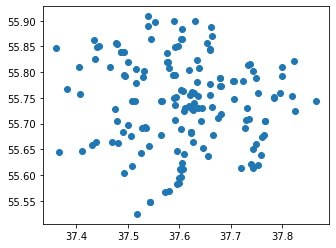

In [ ]:
moscow = train[train['city'] == 'Москва'].reset_index(drop=True)
moscow.plot();

In [ ]:
lon_min = 36.8031
lat_min = 55.1422
lon_max = 37.9674
lat_max = 56.0212

moscow_bbox = lat_min, lon_min, lat_max, lon_max

In [ ]:
def visualisation(df):
    df = df[(df.lon > lon_min) &
            (df.lon < lon_max) &
            (df.lat > lat_min) &
            (df.lat < lat_max)].reset_index(drop=True)
    
    m = folium.Map(location=[55.60, 37.40], 
                   zoom_start=11, 
                   tiles='cartodbpositron')

    heat_data = [[row['lat'],row['lon']] for index, row in df.iterrows()]


    HeatMap(heat_data,
            radius=10).add_to(m)
    return m

In [ ]:
# распределение target
visualisation(train)

In [ ]:
# распределение ж/д станций
visualisation(railway_osm)

In [ ]:
# распределение автостанций, автовокзалов
visualisation(bus_station_osm)

In [ ]:
# распределение отелей
visualisation(hotel_osm)

In [ ]:
# распределение хостелов
visualisation(hostel_osm)

In [ ]:
# распределение фаст-фуд корнеров
visualisation(fast_food_osm)

In [ ]:
# распределение тц
visualisation(mall_osm)

### Fit model

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train.drop('target', axis=1), train[['target']])
model = LinearRegression().fit(X_train.drop('point_id', axis=1), y_train)

In [ ]:
mean_absolute_error(y_valid, model.predict(X_valid.drop('point_id', axis=1)))

0.6989619688268327

### Make submission

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = model.predict(test.drop('point_id', axis=1))
submission.to_csv('data/my_submission_01.csv', index=False)